In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import logging
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
import random
# import ray
from collections import namedtuple, deque
import time
import copy
from tqdm.notebook import tqdm
sns.set_style('whitegrid')

In [2]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
formatter = logging.Formatter( '%(asctime)s:%(name)s:%(message)s')

if not logger.handlers:
    file_handler = logging.FileHandler('loginfo.log')
    file_handler.setLevel(logging.INFO)
    file_handler.setFormatter(formatter)
    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(formatter)
    logger.addHandler(file_handler)
    logger.addHandler(stream_handler)

## Neural Net model

In [20]:
class MLPPolicy(nn.Module):
    def __init__(self, in_dim, out_dim):
        """Create a MLP neural network to be a policy
        parameters: 
            in_dim: int,  input dimension
            out_dim: int, output dimension
        return: logits
        """
        super(MLPPolicy, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear1 = nn.Linear(self.in_dim, 64)
        self.bn1 = nn.BatchNormalization()
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32,self.out_dim )
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim = 0)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        return x
            


## Memory Replay

In [21]:
class MemoryReplay(object):
    """Memmory class to save experiences"""
    def __init__(self, maxlen,batch_size, seed, device):
        """
        params:
            maxlen: max len of memory
            batch_size: number of experiences are sampled each time sample is called
            seed: set seed for random, for reproducible purpose
        """
        self.maxlen = maxlen
        self.seed = seed
        self.memory = deque(maxlen  = self.maxlen)
        self.experience = namedtuple('Experience', field_names= ['state', 'action', 'reward', 'next_state', 'done'])
        self.batch_size = batch_size
        self.device = device
        random.seed(self.seed)

    
    def sample(self, n_experiences = None):
        """
        Sample n_experiences from the memory
        return pytorch tensors of experiences: states, actions, rewards, next_states, dones 
        """
        if n_experiences is None:
            n_experiences = self.batch_size
        
        samples = random.sample(self.memory, n_experiences)
        states, actions, rewards, next_states, dones = np.array([x.state for x in samples]) , np.array([x.action for x in samples]), np.array([x.reward for x in samples]),\
         np.array([x.next_state for x in samples]), np.array([x.done for x in samples])
         
        # logger.info(f'1 example of experience sample from memory: state: {states[0]} action: {actions[0]} reward {rewards[0]} next_state: {next_states[0]} done: {dones[0]}')
        assert type(states) == np.ndarray, 'states is expected to be np.ndarray'
        assert len(states) == len(actions) == len(rewards) == len(next_states) == len(dones), 'len does not match'
        # ndarray into pytorch tensors
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).float().unsqueeze(-1).to(self.device)
        rewards = torch.from_numpy(rewards).float().unsqueeze(-1).to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        dones = torch.from_numpy(dones).float().unsqueeze(-1).to(self.device)
        # logger.info(f'Shape of tensor return from memory class: \n states.size() = {states.size()}, actions.size() = {actions.size()}, rewards.size() = {rewards.size()}, next_states.size() = {next_states.size()}, dones.size() = {dones.size()}')
        # is the shape right?
        return states, actions, rewards, next_states, dones

        

    def add_experiences(self, experiences):
        """
        Add many experiences to the memory
        Experiences is expected to be a list of lists: states, actions, rewards, next_states, dones
        """
        num_experiences = len(experiences[0])
        assert type(experiences) == list, 'Experiences is expected to be a list of lists: state, action, reward, next_state, done'
        self.memory.extend([self.experience(state, action, reward, next_state, done) for state, action, reward,next_state,  done in zip(*experiences)])
        # logger.info(f'Add {num_experiences} experiences to memory, below are five last added experiences: ')
        # for i in range(5):
        #     experience = self.memory[-i]
        #     logger.info(f"{i}. state: {experience.state} action: {experience.action} reward: {experience.reward} next_state: {experience.next_state} done: {experience.done} ")

    def __len__(self):
        return len(self.memory)


In [22]:
class VanillaDQN(object):
    """
    Implementation of vanilla DQN, use boltzmann policy
    """
    def __init__(self, policy ,environment,  args ):
        """
        parameters:
            policy: an random initialized MLP policy
            environment: a gym environment
            optimizer: pytorch optimizer

            args: dictionary, arguments, args has:
                num_steps: number of step training
                num_experiences_each_step: number of tuple of experience draw from the environment each training step
                learning_rate: learning rate for update the policy
                t: temperature of the boltzmann policy
                num_batchs_per_training_step: number of batch use in each training step
                num_updates_per_batch: number of updates for each batch
            For memory replay:
                batch_size: batch_size sample from replay memory
                replay_memory_size: max size of replay_memory
                seed: seed for memory replay
                device: training device


        The workflow as follow:
            for each step in 0->max_steps - 1:
                1. draw num_experiences_each_step tuple of experiences using the current policy, save to the replay memory
                2. use those experience to calculate the target: Q_tar(s, a) = r + argmax_a'(Q(s',a'))
                3. calculate the predicted Q_value for each tuple of experiences
                4. compute loss, take one step optimization
        """
        
        self.environment = environment

        self.args = args
        self.num_steps = args.num_steps
        self.num_experiences_each_step = args.num_experiences_each_step
        self.learning_rate = args.learning_rate
        self.num_batchs_per_training_step = args.num_batchs_per_training_step
        self.num_updates_per_batch = args.num_updates_per_batch
        self.batch_size = args.batch_size
        self.memory_replay_size = args.memory_replay_size
        
        self.policy = policy.to(self.args.device)
        self.memory = MemoryReplay(self.args.memory_replay_size, self.args.batch_size, self.args.seed, self.args.device )
        self.boltzmann_decay_rate=  self.compute_boltzmann_decay_rate()
        self.boltzmann_temperature = copy.deepcopy(self.args.boltzmann_start_temperature)
        
        self.global_step = 0
        # record reward of all episodes
        self.episode_reward_records = []
    def sample_experiences_from_environment(self, num_experiences = None):
        """ 
        Begining of each step, sample num_experiences_each_step experience tuples
        """
        if num_experiences is None:
            num_experiences = self.args.num_experiences_each_step
        # No need for gradients here
        states, actions, rewards, next_states, dones = [], [], [], [],[]
        self.policy.eval()
        with torch.no_grad():
            while True:
                episode_states, episode_actions, episode_rewards, episode_next_states, episode_dones = self.sample_one_episode()
                # print(np.append(np.array([]), episode_states))
                states.extend(episode_states)
                actions.extend(episode_actions)
                rewards.extend(episode_rewards)
                next_states.extend(episode_next_states)
                dones.extend(episode_dones)
                if len(states) > num_experiences:
                    break
        self.policy.train()
        assert len(states) == len(actions) == len(rewards) == len(next_states) == len(dones)

        # Send experiences to self.memory
        self.memory.add_experiences([states, actions, rewards, next_states, dones])
                
    def sample_one_episode(self):
        """
        Sample one episode from environment
        For the CartPole environment, each time step is +1 reward
        compute return in this method
        """
        state = self.environment.reset()
        states = [state]
        actions = []
        rewards = []
        # no need to save next_states, it is just the states but 1 time step forward
        next_states = []
        dones = []
        # time_steps = 0
        while True:
            action = self.take_action(state)
            next_state, reward, done, info = self.environment.step(action)

            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
            # time_steps += 1
            state = next_state
            if done:
                break        
        self.episode_reward_records.append(np.sum(rewards))
        # we do not count the last state to states, because the last state is in next_states, and the first state is in states, not in next_states
        return np.array(states[:-1]), np.array(actions), np.array(rewards),np.array(next_states), np.array(dones).astype(int)

    def average_reward_last_k_episodes(self, k = 20):
        """Average reward of k last episodes"""
        if len(self.episode_reward_records) < k:
            return np.mean(self.episode_reward_records)
        return np.mean(self.episode_reward_records[-k:])

    def take_action(self, state, policy = 'boltzmann'):
        """
        Return one action given state and current policy, using boltzmann or epsilon-greedy policy
        action return should be a scalar
        """

        q_values = self.policy(torch.tensor(state, dtype = torch.float),)
        # logits example: tensor([0.0196, 0.0094], grad_fn=<AddBackward0>)
        # below is the greedy policy, always choose the action that maximize its q_value
        #action = torch.argmax(q_values).item()


        return self.boltzmann_policy(q_values)


    def calculate_target(self, states, actions, rewards, next_states, dones):
        """
        Calculate the Q_tar for each example in batch
        states, actions, rewards, next_states, dones are expected to be pytorch tensors
        """
        targets = []
        # deactivate batch norm, dropout
        self.policy.eval() 
        # no need to compute gradients

        # logger.info(f'expected tensor size in calculated_target: [ {self.batch_size}, state_size]')
        # logger.info(f'tensor size received in calculate_target: states.size() = {states.size()}, actions.size() = {actions.size()}, rewards.size() = {rewards.size()}, next_states.size() = {next_states.size()}, dones.size() = {dones.size()}')
        next_q_values = []
        with torch.no_grad():
            for reward, next_state, done in zip(rewards, next_states, dones):

                max_next_q_value = self.compute_max_next_q_value(next_state, done)
                next_q_values.append(max_next_q_value)
                q_value = reward + self.args.gamma*max_next_q_value
                targets.append(q_value)
        self.policy.train()
        # will the shape correct?
        # targets has size [batch_size]

        ######## ISSUE HERE: max_next_q_value keep increasing as training progress, cause exploding reward
        # print(np.mean(next_q_values))
        return torch.tensor(targets, dtype= torch.float).unsqueeze(-1)################################################# Check shape return


    def compute_max_next_q_value(self, next_state, done):
        """compute the maximum q value of next state"""
        if done:
            return 0
        else:
            return torch.max(self.policy(next_state)).item()

    def predict_q_values(self, states, actions):
        """
        Predict q values of all action
        parameters: 
            states: tensor of shape [batch_size, state_size]
            actions: tensor of shape[batch_size]
        return a tensor of shape [batch_size] of predicted q value for each sample
        this time we need gradient
        """
        predicted = self.policy(states).gather(1, actions.long())
        
        return predicted
        

    ####################################### Methods below are about the Boltzmann policy and epsilon greedy policy###############################
    def boltzmann_policy(self, q_values, ):
        """
        Boltzmann policy for chossing an action

        """
        exp_divide_temperature = torch.exp(q_values/self.boltzmann_temperature)
        # sum = torch.sum(exp_divide_temperature)
        # results = exp_divide_temperature/sum
        try:
            d = torch.distributions.categorical.Categorical(logits = exp_divide_temperature)
        except:
            print(exp_divide_temperature)
            print(self.boltzmann_temperature)
            print(q_values)

        # d = torch.distributions.categorical.Categorical(logits = exp_divide_temperature)
        return d.sample().item()

    def compute_boltzmann_decay_rate(self):
        """ compute the decay rate for boltzmann policy, 
        from start temperature to min temperature in num time steps"""
        assert self.args.boltzmann_start_temperature is not None, 'start temperature must be specified'
        assert self.args.boltzmann_min_temperature is not None, 'min temperature must be specified'
        assert self.args.boltzmann_num_decay_steps is not None, 'num decay steps must be specified'

        decay_rate = np.log(self.args.boltzmann_min_temperature/self.args.boltzmann_start_temperature)/self.args.boltzmann_num_decay_steps
        return decay_rate

    def update_boltzmann_temperature(self):
        """ Update the boltzmann temperature each global time step"""
        if self.boltzmann_temperature <= self.args.boltzmann_min_temperature:
            self.boltzmann_temperature = self.args.boltzmann_min_temperature
            return
        self.boltzmann_temperature = self.args.boltzmann_start_temperature*np.exp(self.boltzmann_decay_rate*self.global_step)
        
    def epsilon_greedy(self, q_values, epsilon):
        """
        Epsilon-greedy policy for choosing an action
        """
        #if epsilon is None:
            
        

    ######################################### End of Boltzmann and epsilon greedy section here #################################################################


    

# calculate the target, the predicted value, 


## Trainer class

In [65]:
class Trainer(object):
    """
    Trainer class for training agent

    Training loop as follow:
        1. for step to max_step:
            Gather experiences

            2. for batch to num_batch_each_step:
                sample a batch from memory
                
                3. for upate in num_update_each_batch:
                    calculate targets of each example in batch
                    calculate predicted q_value of each example in batch

                calculate loss, take one step parameters update

            decay temperature of boltzmann policy
    """
    def __init__(self,agent, args ):
        self.agent = agent
        self.args = args
        self.optimizer = torch.optim.Adam(self.agent.policy.parameters(), lr = self.args.learning_rate)
        self.loss_function = torch.nn.MSELoss()
        # Average rewards received each training step
        self.average_rewards = []
        # losses each time steps
        self.losses = []
    
    def L2_weight_regularization(self, l2_lambda):
        """Return the L2 regularization of the policy weights"""
        l2_reg = torch.tensor(0.)
        for param in self.agent.policy.parameters():
            l2_reg += torch.norm(param)
        return l2_reg*l2_lambda

    def train(self):
        """
        Training agent with hyperparameter specified in agent.args
        """
        for step in tqdm(range(self.args.num_steps)):
            #Gather experiences
            self.agent.sample_experiences_from_environment()
            for batch in range(self.args.num_batchs_per_training_step):
                #sample a batch
                temp_losses = []
                states, actions, rewards, next_states, dones = self.agent.memory.sample()
                for update in range(self.args.num_updates_per_batch):
                    self.optimizer.zero_grad()

                    # compute Q targets, Q predicted
                    # calculate loss and update policy parameters
                    targets = self.agent.calculate_target(states, actions, rewards, next_states, dones) # shape maybe [batch_size]
                    preds = self.agent.predict_q_values(states, actions) # shape maybe [batch_size]

                    loss = self.loss_function(preds, targets)
                    loss += self.L2_weight_regularization(self.args.l2_lambda)

                    loss.backward()
                    self.optimizer.step()
                    temp_losses.append(loss.detach().item())
            self.losses.append(np.mean(temp_losses))
            self.agent.update_boltzmann_temperature()
            self.average_rewards.append(self.agent.average_reward_last_k_episodes( k = 20))
            self.agent.global_step +=1
            if self.agent.global_step%100==0:
                print(f'Current loss: {self.losses[-1]}, current reward average: {self.average_rewards[-1]}')    
        return self.agent    
    def plot_learning_progress(self):
        """ plot the average rewards and losses as training progress"""
        plt.clf()
        fig, axs = plt.subplots(1, 2, figsize = (12, 4))
        print(self.agent.global_step)
        print(len(self.average_rewards))
        sns.lineplot(x = np.arange(self.agent.global_step), y = self.average_rewards, ax = axs[0], )
        sns.lineplot(x = np.arange(self.agent.global_step), y = self.losses, ax = axs[1], )

        axs[0].set_xlabel('Training steps')
        axs[0].set_ylabel('reward')
        axs[1].set_xlabel('Training steps')
        axs[1].set_ylabel('loss')

In [66]:
"""
USER MANUAL
-----------------------------
    Trainer class for training agent

    Training loop as follow:
        1. for step to max_step:
            Gather experiences

            2. for batch to num_batch_each_step:
                sample a batch from memory
                
                3. for upate in num_update_each_batch:
                    calculate targets of each example in batch
                    calculate predicted q_value of each example in batch

                calculate loss, take one step parameters update

            decay temperature of boltzmann policy
---------------------------------------------------
Hyperparameters:
    gamma: the discounted reward
    num_steps: total number of steps to train agent
    num_experiences_each_step: number of experiences example drawn from environment when each training step begin
    learning_rate: learning rate of optimizer
    boltzmann_start_temperature: start temperature of boltzmann policy, if use boltzmann policy to choose action, which is default
    boltzmann_min_temperature: minimum temperature of boltzmann policy
    boltzmann_num_decay_step: boltzmann temperature will be decayed from start temperature to min temperature in this number of steps, 
        decay fomular: f(t) = start_temp*e^(decay_rate*t), 
        it is a function of time step, the decay rate can be found if solving the aforemention equation, with t equal boltzmann_num_decay_step  
    num_batchs_per_training_step: each training step, this number of batch will be sampled to train policy
    num_updates_per_batch: for each batch sampled above, it will be used to update the policy this number of times
    batch_size: number of examples each batch
    memory_replay_size: maximum size of replay memory
    seed: this seed is set for memory class, use to sample batch
    device: training on cpu or gpu, this code still not support GPU training, it easy, just a few modification, i'll do it later
    num_episodes_to_average_reward: when training, print out the average reward received from  num_episodes_to_average_reward last episode
    l2_lambda: L2 weight regularization on policy parameters

The training progress is very much depend on the start temperature, end temperature and num decay step.
"""

args = edict({
'gamma': 0.9,
'num_steps': 2000,
'num_experiences_each_step': 500,
 'learning_rate': 0.0005,
 'boltzmann_start_temperature': 10, 
 'boltzmann_min_temperature': 1,
 'boltzmann_num_decay_steps': 1900,

'num_batchs_per_training_step': 5, 
'num_updates_per_batch': 1, 
'batch_size': 128,
 'memory_replay_size': 10000, 
 'seed': 42, 
 'device': 'cpu',
 'num_episodes_to_average_reward': 10,
 'l2_lambda': 0.01
})

env = gym.make('CartPole-v1')
# A neural network: 4->64->64->2
policy = MLPPolicy(4, 2)


In [68]:

dqn = VanillaDQN(policy, env, args)
trainer = Trainer(dqn, args)

In [70]:
agent = trainer.train()

Current loss: 1.6439473628997803, current reward average: 29.3
Current loss: 1.3600578308105469, current reward average: 25.6
Current loss: 1.0181035995483398, current reward average: 43.0
Current loss: 0.9786249995231628, current reward average: 48.45
Current loss: 1.5833754539489746, current reward average: 91.7
Current loss: 0.3598023056983948, current reward average: 138.8
Current loss: 0.2614494562149048, current reward average: 151.25
Current loss: 0.22776013612747192, current reward average: 292.45
Current loss: 0.5282162427902222, current reward average: 308.1
Current loss: 0.8262212872505188, current reward average: 408.15
Current loss: 0.18196727335453033, current reward average: 482.85
Current loss: 0.18597836792469025, current reward average: 232.2
Current loss: 0.17493195831775665, current reward average: 282.95
Current loss: 0.1616327464580536, current reward average: 465.75
Current loss: 0.15638674795627594, current reward average: 397.5
Current loss: 0.1537558138370514,

In [ ]:
# Render env
!apt install xvfb
!pip install pyvirtualdisplay
!pip install gym-notebook-wrapper
# !pip install gym-chess
!apt update && apt install xvfb
!apt update && apt install python-opengl ffmpeg
import gnwrapper
import gym




In [71]:
# Evaluate agent
env = gym.make('CartPole-v1')
def evaluate(agent, env, num_episodes):
    
    rewards = []
    for i in range(0, num_episodes):
        total_reward = 0
        state = env.reset()
        
        while True:
            action = torch.argmax(agent.policy(torch.tensor(state, dtype= torch.float))).item()
            next_state, reward, done, info = env.step(action)
            state = next_state
            total_reward += reward
            if done:
                break
        rewards.append(total_reward)
    return np.mean(rewards)


In [75]:
evaluate(agent, env, 100)

124.82

Total reward: 144.0


KeyboardInterrupt: ignored

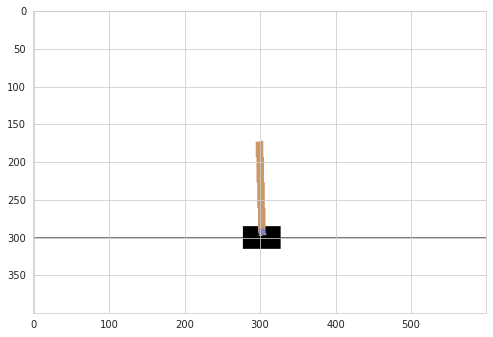

In [30]:
# env = gnwrapper.LoopAnimation(gym.make('CartPole-v0')) # Start Xvfb

state = env.reset()
total_reward = 0
with torch.no_grad():
    while True:
        q_values = agent.policy(torch.tensor(state, dtype= torch.float).unsqueeze(0))
        action = torch.argmax(q_values).item()
        # print(action)
        # print(q_values)
        # print(torch.tensor(state, dtype= torch.float))
        next_state, reward, done, info = env.step(action) # Take action from DNN
        state = next_state
        total_reward += reward
        env.render() # Here, store display images
        if done:
            break

    print(f"Total reward: {total_reward}")
    env.display()